# Verification experiments
_Author: Bart van Erp_ 

_Date:   07-02-2022_

This notebook contains the verification experiments to the paper **Model-Based Source Separation Using Invertible Neural Networks**.

## Load packages

In [ ]:
using Revise
using SourceSeparationINN
using LinearAlgebra, Random, Distributions
using HDF5, JLD2
using PyPlot

BLAS.set_num_threads(1)
Random.seed!(1234);

## Load data

In [2]:
# generate data if it does not exist yet
t = 0:0.01:10
if !isdir("data")

    # create folders
    mkdir("data")
    mkdir("data/signal")
    mkdir("data/noise")
    mkdir("data/mix")
    mkdir("data/mix_signal")
    mkdir("data/mix_noise")

    # generate data and save
    start_signal = 10*randn(1000)
    start_noise  = 10*randn(1000)
    start_mix    = 10*randn(1000)
    amps         = 5*rand(1000)
    for k = 1:1000
        h5write(string("data/signal/", k, ".h5"), "signal", amps[k]* 2 .* ((start_signal[k].+collect(t)).*12 .- floor.(1/2 .+ (start_signal[k].+collect(t)).*12)))
        h5write(string("data/noise/",  k, ".h5"), "signal", amps[k]* sign.(cos.(start_noise[k].+2*π*10*collect(t))))
        h5write(string("data/mix/",    k, ".h5"), "signal", 2 .* (t.*12 .-floor.(1/2 .+ collect(t).*12)) .+ sign.(cos.(start_mix[k].+2*π*10*collect(t))))
        h5write(string("data/mix_signal/", k, ".h5"), "signal", 2 .* (t.*12 .-floor.(1/2 .+ collect(t).*12))) 
        h5write(string("data/mix_noise/",  k, ".h5"), "signal", sign.(cos.(start_mix[k].+2*π*10*collect(t))))
    end

end

In [4]:
# load data
data_signal = Data("data/signal/" .* readdir("data/signal"), Float64)
data_noise  = Data("data/noise/"  .* readdir("data/noise"),  Float64)
data_mix    = Data("data/mix/"    .* readdir("data/mix"),    Float64)
data_mix_signal = Data("data/mix_signal/"    .* readdir("data/mix_signal"), Float64)
data_mix_noise  = Data("data/mix_noise/"    .* readdir("data/mix_noise"),  Float64);

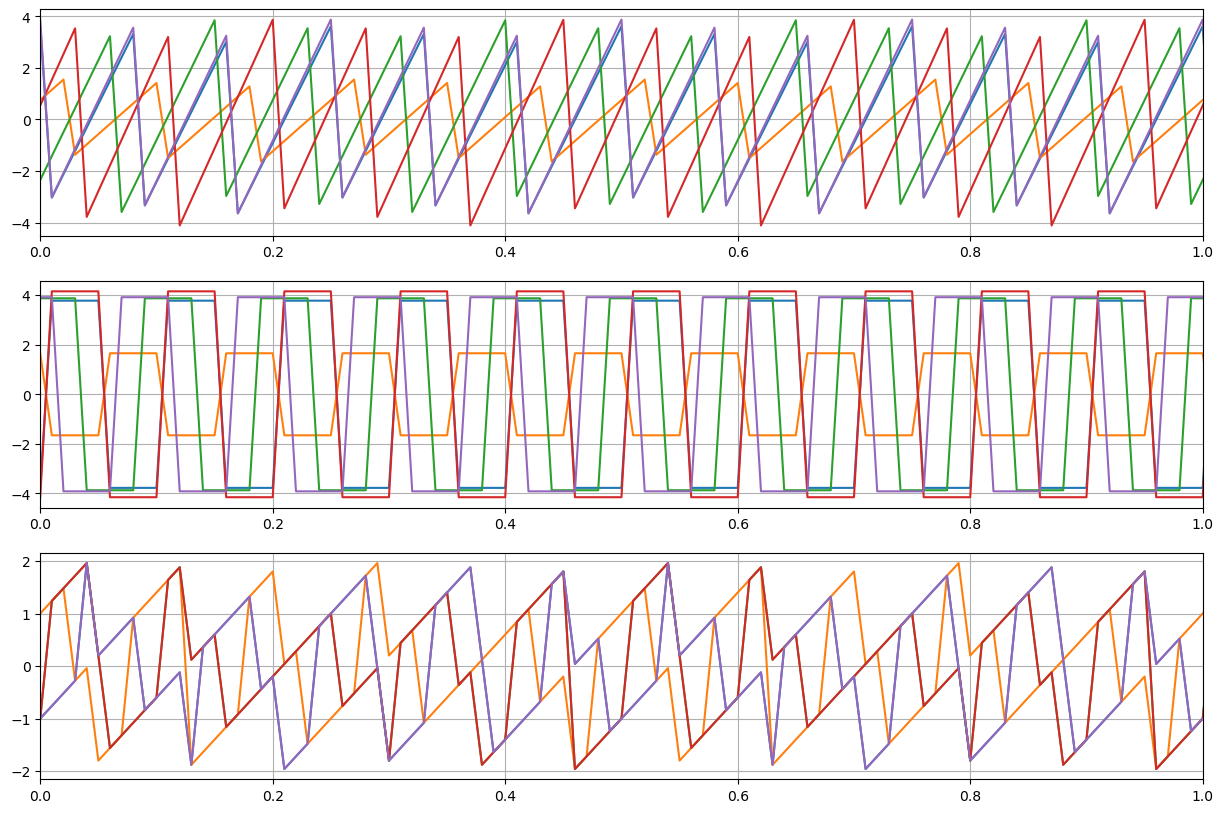

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\s151781\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


In [5]:
_, ax = plt.subplots(figsize=(15,10), nrows=3)
for k in 1:5
    ax[1].plot(t, data_signal[k])
    ax[2].plot(t, data_noise[k])
    ax[3].plot(t, data_mix[k])
end
ax[1].set_xlim(0,1), ax[1].grid()
ax[2].set_xlim(0,1), ax[2].grid()
ax[3].set_xlim(0,1), ax[3].grid();

## Train models

In [6]:
function create_nar_model(dim; shift=1, optimizer::Type{<:AbstractOptimizer}=Adam, batch_size::Int=128)

    return Model(dim,
        (   
            NarLayer(dim,
                Model(dim-shift, shift,
                    (
                        DenseLayer(dim-shift, 16; optimizer=optimizer, batch_size=batch_size),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseLayer(16, 16; optimizer=optimizer, batch_size=batch_size),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseLayer(16, 16; optimizer=optimizer, batch_size=batch_size),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseLayer(16, shift; optimizer=optimizer, batch_size=batch_size),
                    ); batch_size=batch_size
                ); batch_size=batch_size
            ),
        ); batch_size=batch_size
    )
end
batch_size = 16
dim_in = 16
loss_function_signal = MSE(batch_size=batch_size)
loss_function_noise  = MSE(batch_size=batch_size)
;

In [7]:
# load/train signal model
if isdir("logs/signal")

    # load model
    model_signal = load(string("logs/signal/", readdir("logs/signal")[1], "/model.jld2"))["model"]

else

    # create model
    model_signal = create_nar_model(dim_in; batch_size=batch_size)

    # set learning rate
    setlr!(model_signal, 1e-5)

    # create train suite
    train_suite_signal = TrainSuite(
        model_signal,           # model
        loss_function_signal,   # loss function
        data_signal,            # train data
        data_signal,            # test data
        10,                     # number of epochs
        "logs/signal/"          # path to log directory
    );

    # create folder
    mkdir("logs/signal")

    # train model
    run!(train_suite_signal)

end;

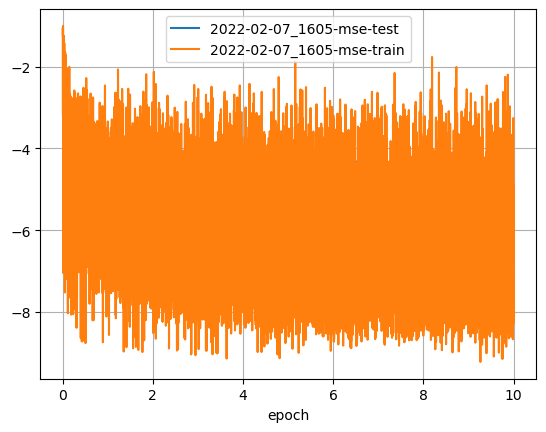

In [8]:
plot_logs(; path="logs/signal/", logscale=true);

In [9]:
# load/train noise model
if isdir("logs/noise")

    # load model
    model_noise = load(string("logs/noise/", readdir("logs/noise")[1], "/model.jld2"))["model"]

else

    # create model
    model_noise = create_nar_model(dim_in; batch_size=batch_size)

    # set learning rate
    setlr!(model_noise, 1e-5)

    # create train suite
    train_suite_noise = TrainSuite(
        model_noise,           # model
        loss_function_noise,   # loss function
        data_noise,            # train data
        data_noise,            # test data
        10,                    # number of epochs
        "logs/noise/"          # path to log directory
    );

    # create folder
    mkdir("logs/noise")

    # train model
    run!(train_suite_noise)

end;

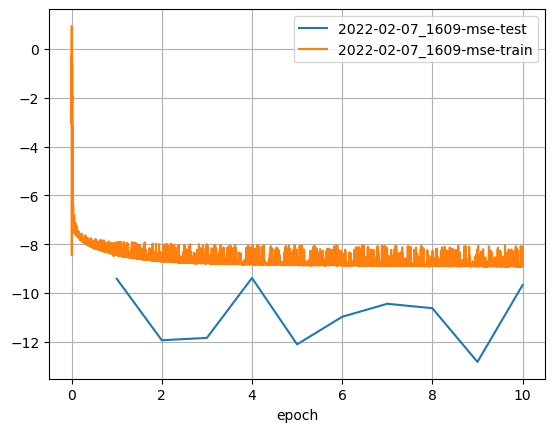

In [10]:
plot_logs(; path="logs/noise/", logscale=true);

## Kalman priors

In [11]:
H = zeros(3,2*dim_in)
H[1,1] = 1
H[1,1+dim_in] = 1
H[2,1] = 0
H[3, 1+dim_in] = 0

Q = zeros(2*dim_in, 2*dim_in)
R = [1e-10 0 0; 0 1e3 0; 0 0 1e3]# 1e-3
Q[1,1] = exp(-8) * dim_in
Q[1+dim_in, 1+dim_in] = exp(-8) * dim_in

signal_mix = data_mix[1]

m_x_prior = randn(2*dim_in)
# m_x_prior = vcat(data_mix_signal[1][16:-1:1], data_mix_noise[1][16:-1:1])
V_x_prior = 1e2*diagm(ones(2*dim_in));
# V_x_prior = 1e-1*diagm(ones(2*dim_in));

## Extended Kalman filter/smoother

In [12]:
function EKF(signal_mix, model_signal, model_noise, m_x_prior, V_x_prior, H, R, Q; dim_in=16)

    # allocate output
    m_x_f = Vector{Vector{Float64}}(undef,length(signal_mix))
    V_x_f = Vector{Matrix{Float64}}(undef,length(signal_mix))
    m_x_s = Vector{Vector{Float64}}(undef,length(signal_mix))
    V_x_s = Vector{Matrix{Float64}}(undef,length(signal_mix))

    # copy priors
    m_x = copy(m_x_prior)
    V_x = copy(V_x_prior)

    # kalman filtering
    for k in dim_in+1:length(signal_mix)
    
        # predict step
        m_x_new = vcat(forward(model_signal, m_x[1:dim_in]), forward(model_noise, m_x[dim_in+1:end]))
        F = vcat(hcat(jacobian(model_signal, m_x[1:dim_in]), zeros(dim_in, dim_in)), hcat(zeros(dim_in, dim_in), jacobian(model_noise, m_x[dim_in+1:end])))
        V_x_new = F*V_x*F' + Q
    
        # filtering messages
        y = [signal_mix[k],0,0] - H*m_x_new
        S = H*V_x_new*H' + R
        K = V_x_new * H' * inv(S)
        m_x = m_x_new + K*y
        # V_x = V_x_new - K*S*K'
        V_x = (I - K*H)*V_x_new
    
        # save values
        m_x_f[k] = copy(m_x)
        V_x_f[k] = copy(V_x)
    
    end

    # copy output
    m_x_new = copy(m_x_f[end])
    V_x_new = copy(V_x_f[end])
    m_x_s[end] = copy(m_x_f[end])
    V_x_s[end] = copy(V_x_f[end])

    # kalman smoothing
    for k in length(signal_mix)-1:-1:1+dim_in

        # pass through equality node (and H)
        G = cholinv(R + H*V_x_new*H')
        m_x = m_x_new + V_x_new*H'*G*([signal_mix[k+1],0,0] - H*m_x_new) # to check
        V_x = V_x_new - V_x_new * H' * G * H * V_x_new

        # pass through non-linear node
        m_x_new = vcat(backward(model_signal, m_x[1:dim_in]), backward(model_noise, m_x[dim_in+1:end]))
        F = vcat(hcat(invjacobian(model_signal, m_x[1:dim_in]), zeros(dim_in, dim_in)), hcat(zeros(dim_in, dim_in), invjacobian(model_noise, m_x[dim_in+1:end])))
        V_x_new = F*(V_x+Q)*F'    

        # save values
        m_x_s[k] = copy(m_x_new)
        V_x_s[k] = copy(V_x_new)

    end

    # process output to something meaningful
    V_x_marg = [cholinv(cholinv(V_x_s[k])+cholinv(V_x_f[k])) for k = dim_in+1:length(signal_mix)]
    m_x_marg = [V_x_marg[k-dim_in] * (cholinv(V_x_s[k])*m_x_s[k] + cholinv(V_x_f[k])*m_x_f[k]) for k = dim_in+1:length(signal_mix)]

    m_signal_filtering = [m_x_f[k][1]                       for k = dim_in+1:length(signal_mix)]
    V_signal_filtering = [V_x_f[k][1,1]                     for k = dim_in+1:length(signal_mix)]
    m_signal_smoothing = [m_x_marg[k][1]                    for k = 1:length(m_x_marg)]
    V_signal_smoothing = [V_x_marg[k][1,1]                  for k = 1:length(V_x_marg)]
    m_noise_filtering  = [m_x_f[k][1+dim_in]                for k = dim_in+1:length(signal_mix)]
    V_noise_filtering  = [V_x_f[k][1+dim_in,1+dim_in]       for k = dim_in+1:length(signal_mix)]
    m_noise_smoothing  = [m_x_marg[k][1+dim_in]             for k = 1:length(m_x_marg)]
    V_noise_smoothing  = [V_x_marg[k][1+dim_in,1+dim_in]    for k = 1:length(V_x_marg)]

    # return output
    m_signal_filtering, V_signal_filtering, m_signal_smoothing, V_signal_smoothing, m_noise_filtering, V_noise_filtering, m_noise_smoothing, V_noise_smoothing
    
end

EKF (generic function with 1 method)

In [13]:
m_signal_filtering, V_signal_filtering, m_signal_smoothing, V_signal_smoothing, m_noise_filtering, V_noise_filtering, m_noise_smoothing, V_noise_smoothing = EKF(signal_mix, model_signal, model_noise, m_x_prior, V_x_prior, H, R, Q);

#### Filtering distribution

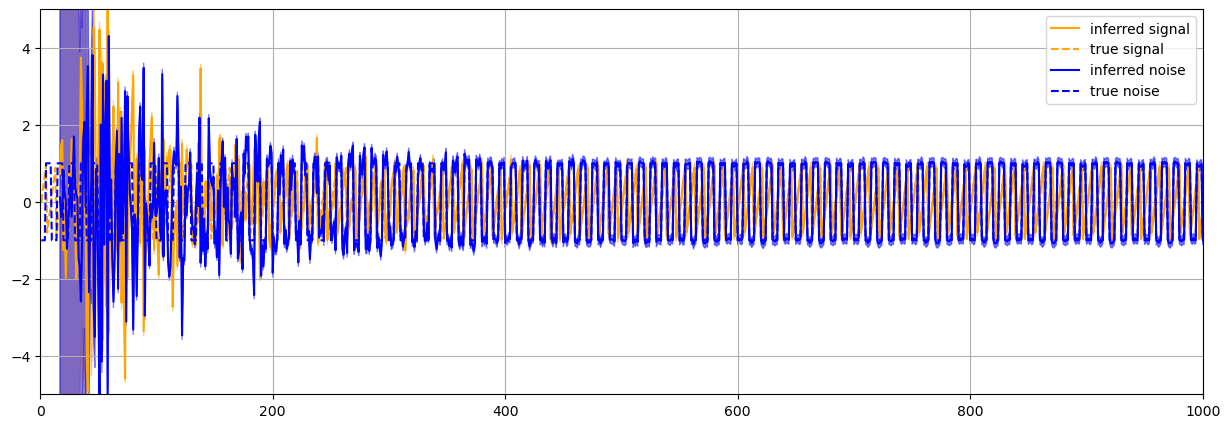

In [14]:
plt.figure(figsize=(15,5))
plt.fill_between(dim_in+1:length(data_signal[1]), m_signal_filtering+sqrt.(V_signal_filtering), m_signal_filtering-sqrt.(V_signal_filtering), color="orange", alpha=0.5)
plt.plot(dim_in+1:length(data_signal[1]), m_signal_filtering, color="orange", label="inferred signal")
plt.plot(1:length(data_signal[1]), data_mix_signal[1], color="orange", linestyle="--", label="true signal")
plt.fill_between(dim_in+1:length(data_signal[1]), m_noise_filtering+sqrt.(V_noise_filtering), m_noise_filtering-sqrt.(V_noise_filtering), color="blue", alpha=0.5)
plt.plot(dim_in+1:length(data_signal[1]), m_noise_filtering, color="blue", label="inferred noise")
plt.plot(1:length(data_signal[1]), data_mix_noise[1], color="blue", linestyle="--", label="true noise")
plt.grid()
plt.legend()
plt.ylim(-5,5)
plt.xlim(0,1000);

#### Smoothing distribution

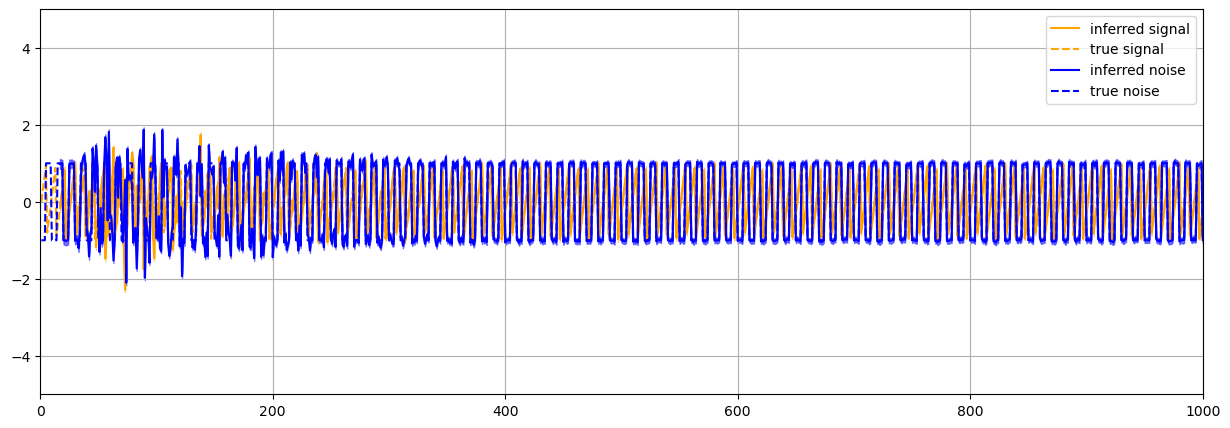

In [15]:
plt.figure(figsize=(15,5))
plt.fill_between(dim_in+1:length(data_signal[1]), m_signal_smoothing+sqrt.(V_signal_smoothing), m_signal_smoothing-sqrt.(V_signal_smoothing), color="orange", alpha=0.5)
plt.plot(dim_in+1:length(data_signal[1]), m_signal_smoothing, color="orange", label="inferred signal")
plt.plot(1:length(data_signal[1]), data_mix_signal[1], color="orange", linestyle="--", label="true signal")
plt.fill_between(dim_in+1:length(data_signal[1]), m_noise_smoothing+sqrt.(V_noise_smoothing), m_noise_smoothing-sqrt.(V_noise_smoothing), color="blue", alpha=0.5)
plt.plot(dim_in+1:length(data_signal[1]), m_noise_smoothing, color="blue", label="inferred noise")
plt.plot(1:length(data_signal[1]), data_mix_noise[1], color="blue", linestyle="--", label="true noise")
plt.grid()
plt.legend()
plt.ylim(-5,5)
plt.xlim(0,1000);

#### metrics

In [16]:
MSE_filtering  = Vector{Float64}(undef, length(data_mix))
MSE_smoothing  = Vector{Float64}(undef, length(data_mix))
MAE_filtering  = Vector{Float64}(undef, length(data_mix))
MAE_smoothing  = Vector{Float64}(undef, length(data_mix))
logp_filtering = Vector{Float64}(undef, length(data_mix))
logp_smoothing = Vector{Float64}(undef, length(data_mix))

for (ind, signal_mix) in enumerate(data_mix)

    # run EKF
    m_signal_filtering, V_signal_filtering, m_signal_smoothing, V_signal_smoothing, m_noise_filtering, V_noise_filtering, m_noise_smoothing, V_noise_smoothing = EKF(signal_mix, model_signal, model_noise, m_x_prior, V_x_prior, H, R, Q);

    # calculate metrics
    MSE_filtering[ind]  = sum(abs2.(m_signal_filtering .- data_mix_signal[ind][dim_in+1:end]))/length(m_signal_filtering)
    MSE_smoothing[ind]  = sum(abs2.(m_signal_smoothing .- data_mix_signal[ind][dim_in+1:end]))/length(m_signal_smoothing)
    MAE_filtering[ind]  = sum(abs.(m_signal_filtering .- data_mix_signal[ind][dim_in+1:end]))/length(m_signal_filtering)
    MAE_smoothing[ind]  = sum(abs.(m_signal_smoothing .- data_mix_signal[ind][dim_in+1:end]))/length(m_signal_smoothing)
    logp_filtering[ind] = sum([logpdf(Normal(m_signal_filtering[k], sqrt(V_signal_filtering[k])), data_mix_signal[ind][k+dim_in]) for k=1:length(m_signal_filtering)])/length(m_signal_filtering)
    logp_smoothing[ind] = sum([logpdf(Normal(m_signal_smoothing[k], sqrt(V_signal_smoothing[k])), data_mix_signal[ind][k+dim_in]) for k=1:length(m_signal_smoothing)])/length(m_signal_smoothing)

end

In [24]:
mean(MSE_filtering), mean(MSE_smoothing), mean(MAE_filtering), mean(MAE_smoothing), mean(logp_filtering), mean(logp_smoothing)

(0.2910646379514895, 0.0704912046539648, 0.21934818312984874, 0.13172644447455148, -5.383231849776509, -11.82090238024933)